# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.715005,True,5.659198
1,-1.620697,False,-3.125415
2,-1.752493,False,-3.144005
3,0.013939,True,6.889675
4,-0.673255,True,3.454869
...,...,...,...
995,-1.057805,True,4.873714
996,-0.327193,True,3.347015
997,0.186486,True,3.773212
998,-0.116920,False,-0.145078


<AxesSubplot:xlabel='v0'>

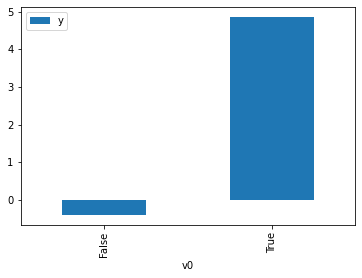

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

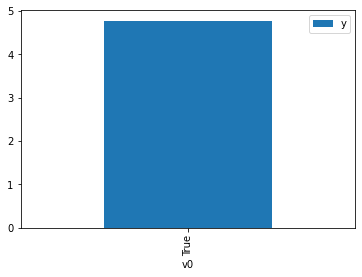

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.317029,False,-0.392311,0.409689,2.440874
1,-0.637205,False,-1.420445,0.717270,1.394176
2,-0.149389,False,-1.816512,0.566681,1.764662
3,-0.149389,False,-1.816512,0.566681,1.764662
4,0.560838,False,0.370359,0.332603,3.006583
...,...,...,...,...,...
995,0.225082,False,0.172930,0.440200,2.271696
996,-0.548771,False,-1.950298,0.692287,1.444488
997,1.326658,False,1.728349,0.149732,6.678607
998,0.566108,False,0.540323,0.331016,3.020999


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.505391,True,4.524817,0.320406,3.121038
1,-0.467810,True,5.720615,0.331622,3.015478
2,0.554513,True,6.493333,0.665487,1.502660
3,0.337231,True,7.046618,0.596930,1.675237
4,-0.087099,True,3.141479,0.454202,2.201665
...,...,...,...,...,...
995,-0.128905,True,6.423158,0.440164,2.271880
996,0.072927,True,4.669278,0.508416,1.966892
997,0.306562,True,6.961555,0.586868,1.703962
998,0.909117,True,5.110660,0.763060,1.310513


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              8004.
Date:                Wed, 27 Jul 2022   Prob (F-statistic):                        0.00
Time:                        13:54:38   Log-Likelihood:                         -1425.2
No. Observations:                1000   AIC:                                      2854.
Df Residuals:                     998   BIC:                                      2864.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3570      0.033     41.680      0.000       1.293       1.421
x2             5.0511      0.049    102.457      0.000       4.954       5.148
==============================================================================
Omnibus:                       11.782   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.868
Skew:                           0.251   Prob(JB):                      0.00265
Kurtosis:                       3.183   Cond. No.                         1.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""